# GAN on CelebA Dataset

## Problem Description
We will try to generate celebrity faces from the CelebA large scale Large-scale CelebFaces Attributes Dataset. It has 202 thousand images of celebrity faces. We will target the generation of lower resolution and colored (RGB) 45x45x3 pixels images using a VAE.

# Prepare the Data

The dataset can be downloaded from the following website - 
https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
We will only use the images and not the annotations for our task, because we are targeting unconditional generation of images.

## Prepare downsampled, cropped data

As mentioned before, we will target the generation of 45x45x3 center cropped images. The dataset can be downloaded from 

https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ

We will prepare the data with the help of tensorflow jpeg decode function and save it as numpy data for further use.

In [ ]:
import zipfile
from tqdm import tqdm
import numpy as np
import gzip
import tensorflow as tf


# The dataset 'img_align_celeba.zip' is downloaded from
# https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
with zipfile.ZipFile('img_align_celeba.zip', 'r') as file:
    image_files = [f.filename for f in file.filelist if (not f.is_dir()) and f.filename.endswith('.jpg')]
    X_train = np.empty([len(image_files),45,45,3],dtype='uint8')
    for i, filename in enumerate(tqdm(image_files)):
        X_train[i] = tf.io.decode_and_crop_jpeg(file.read(filename),
                                                crop_window=[5,0,45,45],
                                                ratio=4,
                                                channels=3).numpy()
X_train = X_train.squeeze()
with gzip.GzipFile('celeba_gray_45x45x3.npy.gz','wb',5) as save_file:
    np.save(save_file, X_train)

100%|████████████████████████████████████████████████████████████████████████| 202599/202599 [00:44<00:00, 4554.96it/s]


## Load and visualize data

Now that we have saved the data it can be loaded by numpy.

In [1]:
import numpy as np
import gzip

with gzip.GzipFile('celeba_gray_45x45x3.npy.gz','rb') as save_file:
    X_train = np.load(save_file)
X_train = X_train.astype('float32')/255.

Here's a collage of training images.

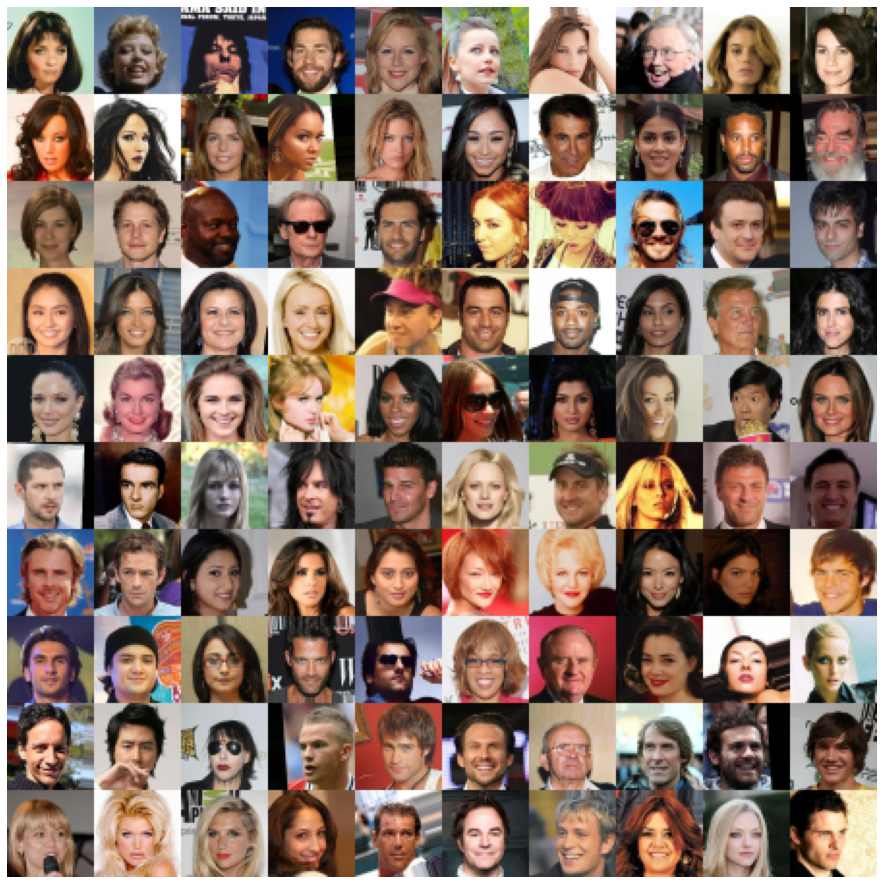

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(X_train[600:700].reshape(10,10,45,45,3).transpose(0,2,1,3,4).reshape(450,450,3))
plt.axis('off')
plt.show()

# GAN

Now we will define our GAN model, train it and generate images.

## Model Definition

We will define a deep convolutional GAN with 4 convolutional layers for both the generator and the discriminator. LeakyReLU will be used as activation which makes the trianing process easier.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, metrics, initializers

latent_dim = 512

def get_discriminator():
    inp = layers.Input(shape=[45,45,3],name='input')
    x = inp

    x = layers.Conv2D(512, (4,4), padding='valid', name='base_conv')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block1_activ1')(x)
    x = layers.Conv2D(512, (4,4), padding='same',
                      strides=(2,2),
                      name='block1_conv2')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block2_activ1')(x)

    # Second Conv block
    x = layers.ZeroPadding2D([(0,1),(0,1)], name='zero_padding1')(x)
    x = layers.Conv2D(512, (4,4), padding='same',
                      strides=(2,2),
                      name='block2_conv2')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block3_activ1')(x)

    # Third Conv block
    x = layers.ZeroPadding2D([(0,1),(0,1)], name='zero_padding2')(x)
    x = layers.Conv2D(512, (4,4), padding='same',
                      strides=(2,2),
                      name='block3_conv2')(x)
    x = layers.LeakyReLU(alpha=0.2, name='final_activ')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outp = layers.Dense(1, name='final_dense')(x)

    model = models.Model(inp, outp, name='discriminator_model')
    return model


def get_generator():
    inp = layers.Input([latent_dim],name='input')
    x = inp

    # x = layers.Dense(512, activation='elu', name='dense1')(x)
    x = layers.Dense(6*6*512, name='dense2')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block1_activ1')(x)
    x = layers.Reshape([6,6,512], name='reshape')(x)

    # First Conv Block
    x = layers.Conv2DTranspose(512, (4,4), padding='same', 
                      strides=(2,2),
                      name='block1_conv1')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block2_activ1')(x)

    # Second Conv Block
    x = layers.Cropping2D([(0,1),(0,1)], name='cropping2')(x)
    x = layers.Conv2DTranspose(512, (4,4), padding='same', 
                      strides=(2,2),
                      name='block2_conv1')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block2_activ2')(x)

    # Third Conv Block
    x = layers.Cropping2D([(0,1),(0,1)], name='cropping3')(x)
    x = layers.Conv2DTranspose(512, (4,4), padding='same', 
                               strides=(2,2),
                               name='block3_conv1')(x)
    x = layers.LeakyReLU(alpha=0.2, name='block3_activ2')(x)
    x = layers.Conv2DTranspose(3, (4,4), padding='valid', 
                               activation='sigmoid', name='final_conv')(x)
    
    outp = x
    model = models.Model(inp, outp, name='generator_model')
    return model

We will use a tensorflow tf.data.Dataset with tf.data.Dataset for a faster training

In [5]:
import numpy as np

batch_size = 32

indices = np.arange(X_train.shape[0], dtype=int)
np.random.shuffle(indices)
train_dataset = tf.data.Dataset.from_tensor_slices(X_train[indices]).shuffle(10000).batch(batch_size).prefetch(-1)

In [6]:
strategy = tf.distribute.MirroredStrategy()
train_dataset = strategy.experimental_distribute_dataset(train_dataset)

with strategy.scope():
    generator_model = get_generator()
    discriminator_model = get_discriminator()

    gen_optim = optimizers.Adam(learning_rate=1e-4)
    gen_loss = losses.BinaryCrossentropy(from_logits=True, 
                                         reduction=losses.Reduction.NONE,
                                         name='gen_loss')
    # gen_loss = losses.MeanSquaredError(reduction=losses.Reduction.NONE, name='gen_loss')
    gen_acc = metrics.BinaryAccuracy(name='gen_acc',threshold=0.)

    disc_optim = optimizers.Adam(learning_rate=1e-4)
    disc_loss = losses.BinaryCrossentropy(from_logits=True,
                                          reduction=losses.Reduction.NONE,
                                        #   label_smoothing=0.1,
                                           name='disc_loss')
    # disc_loss = losses.MeanSquaredError(reduction=losses.Reduction.NONE, name='disc_loss')
    disc_acc = metrics.BinaryAccuracy(name='disc_acc',threshold=0.)

    gen_loss_mean = metrics.Mean(name='gen_loss_mean')
    disc_loss_mean = metrics.Mean(name='disc_loss_mean')

    def compute_gen_loss(y_true, y_pred):
        return tf.nn.compute_average_loss(gen_loss(y_true, y_pred),
                                          global_batch_size=batch_size)
    
    def compute_disc_loss(y_true, y_pred):
        return tf.nn.compute_average_loss(disc_loss(y_true, y_pred),
                                          global_batch_size=batch_size)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Trainining the model

### Training step
In the training step we will add some label noise to the discriminators target labels, so that the discriminator does not become too confident in it's prediction.

In [ ]:
@tf.function
def gan_train_step(batch):
    bsize = tf.shape(batch)[0]
    zero_labels = tf.zeros([bsize,1],dtype=batch.dtype)
    one_labels = tf.ones([bsize,1],dtype=batch.dtype)

    # Generator
    gen_labels = one_labels
    noise = tf.random.normal([bsize,latent_dim])
    
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(generator_model.trainable_weights)
        generated = generator_model(noise, training=True)
        predictions = discriminator_model(generated, training=False)
        loss = compute_gen_loss(gen_labels, predictions)

    grads = tape.gradient(loss, generator_model.trainable_weights)
    gen_optim.apply_gradients(zip(grads, generator_model.trainable_weights))
    gen_acc.update_state(gen_labels, predictions)
    gen_loss_mean.update_state(loss)

    # Discriminator
    disc_real_labels = tf.concat([zero_labels,one_labels],axis=0)
    disc_labels = tf.concat([zero_labels+0.1*tf.random.uniform(tf.shape(zero_labels)),
                             one_labels-0.1*tf.random.uniform(tf.shape(one_labels))],axis=0)
    # disc_labels = disc_real_labels + 0.05*tf.random.uniform(tf.shape(disc_real_labels))
    new_noise = tf.random.normal([bsize,latent_dim])
    fakes = generator_model(new_noise, training=False)
    disc_inp = tf.concat([fakes,batch],axis=0)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(discriminator_model.trainable_weights)
        predictions = discriminator_model(disc_inp, training=True)
        loss = compute_disc_loss(disc_labels, predictions)
    
    grads = tape.gradient(loss, discriminator_model.trainable_weights)
    disc_optim.apply_gradients(zip(grads, discriminator_model.trainable_weights))
    disc_acc.update_state(disc_real_labels,predictions)
    disc_loss_mean.update_state(loss)

In [ ]:
from tqdm import tqdm


class Training:
    def update_progbar(self):
        self.progbar.set_description('Training: '+' ; '.join([
            f'gen_loss:{gen_loss_mean.result().numpy():0.5f}', 
            f'gen_acc:{gen_acc.result().numpy():0.3%}',
            f'disc_loss:{disc_loss_mean.result().numpy():0.5f}',
            f'disc_acc:{disc_acc.result().numpy():0.3%}'
        ]))
        self.progbar.update()
    
    @tf.function
    def training_loop(self):
        for batch in train_dataset:
            strategy.experimental_run_v2(gan_train_step,(batch,))
            tf.py_function(self.update_progbar, [], [])

    def train_epoch(self):
        gen_loss_mean.reset_states()
        gen_acc.reset_states()
        disc_loss_mean.reset_states()
        disc_acc.reset_states()

        self.progbar = tqdm(total=(len(X_train)+batch_size-1)//batch_size)
        try:
            self.training_loop()
        finally:
            self.progbar.close()

    def plot_samples(self):
        noise = np.random.randn(100,latent_dim)
        generated = generator_model.predict_on_batch(noise).numpy()
        plt.figure(figsize=[16,16])
        plt.imshow(generated.reshape(10,10,45,45,3).transpose(0,2,1,3,4).reshape(450,450,3))
        plt.axis('off')
        plt.show()
        plt.pause(0.01)

    def train(self,num_epochs):
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}:',flush=True)
            self.train_epoch()
            generator_model.save_weights('generator_weights.h5')
            discriminator_model.save_weights('discriminator_weights.h5')
            self.plot_samples()

### Training
We trained the model for around 90 epochs. We saved and loaded the weights during these training process.

Saving the the image outputs of the intermediate steps dramatically increases the size of the jupyter notebook, so we cleared the outputs of the following cells. But they are available in the previous GitHub commit of this file.

In [ ]:
training = Training()
training.plot_samples()
training.train(200)

In [ ]:
generator_model.load_weights('generator_weights.h5')
discriminator_model.load_weights('discriminator_weights.h5')

training = Training()
training.plot_samples()
training.train(200)

# Experiments

### Load Weights
Let's load the final saved weights of the model.

In [7]:
generator_model.load_weights('generator_weights.h5')

## Generation Test

We can generate better quality images and avoid distorted images by reducint the standard deviaion (i.e., "temperature") of the input gaussian noise to the decoder. Although this will lead to less diversity in the generated images, they will have higher quality and less distortion.

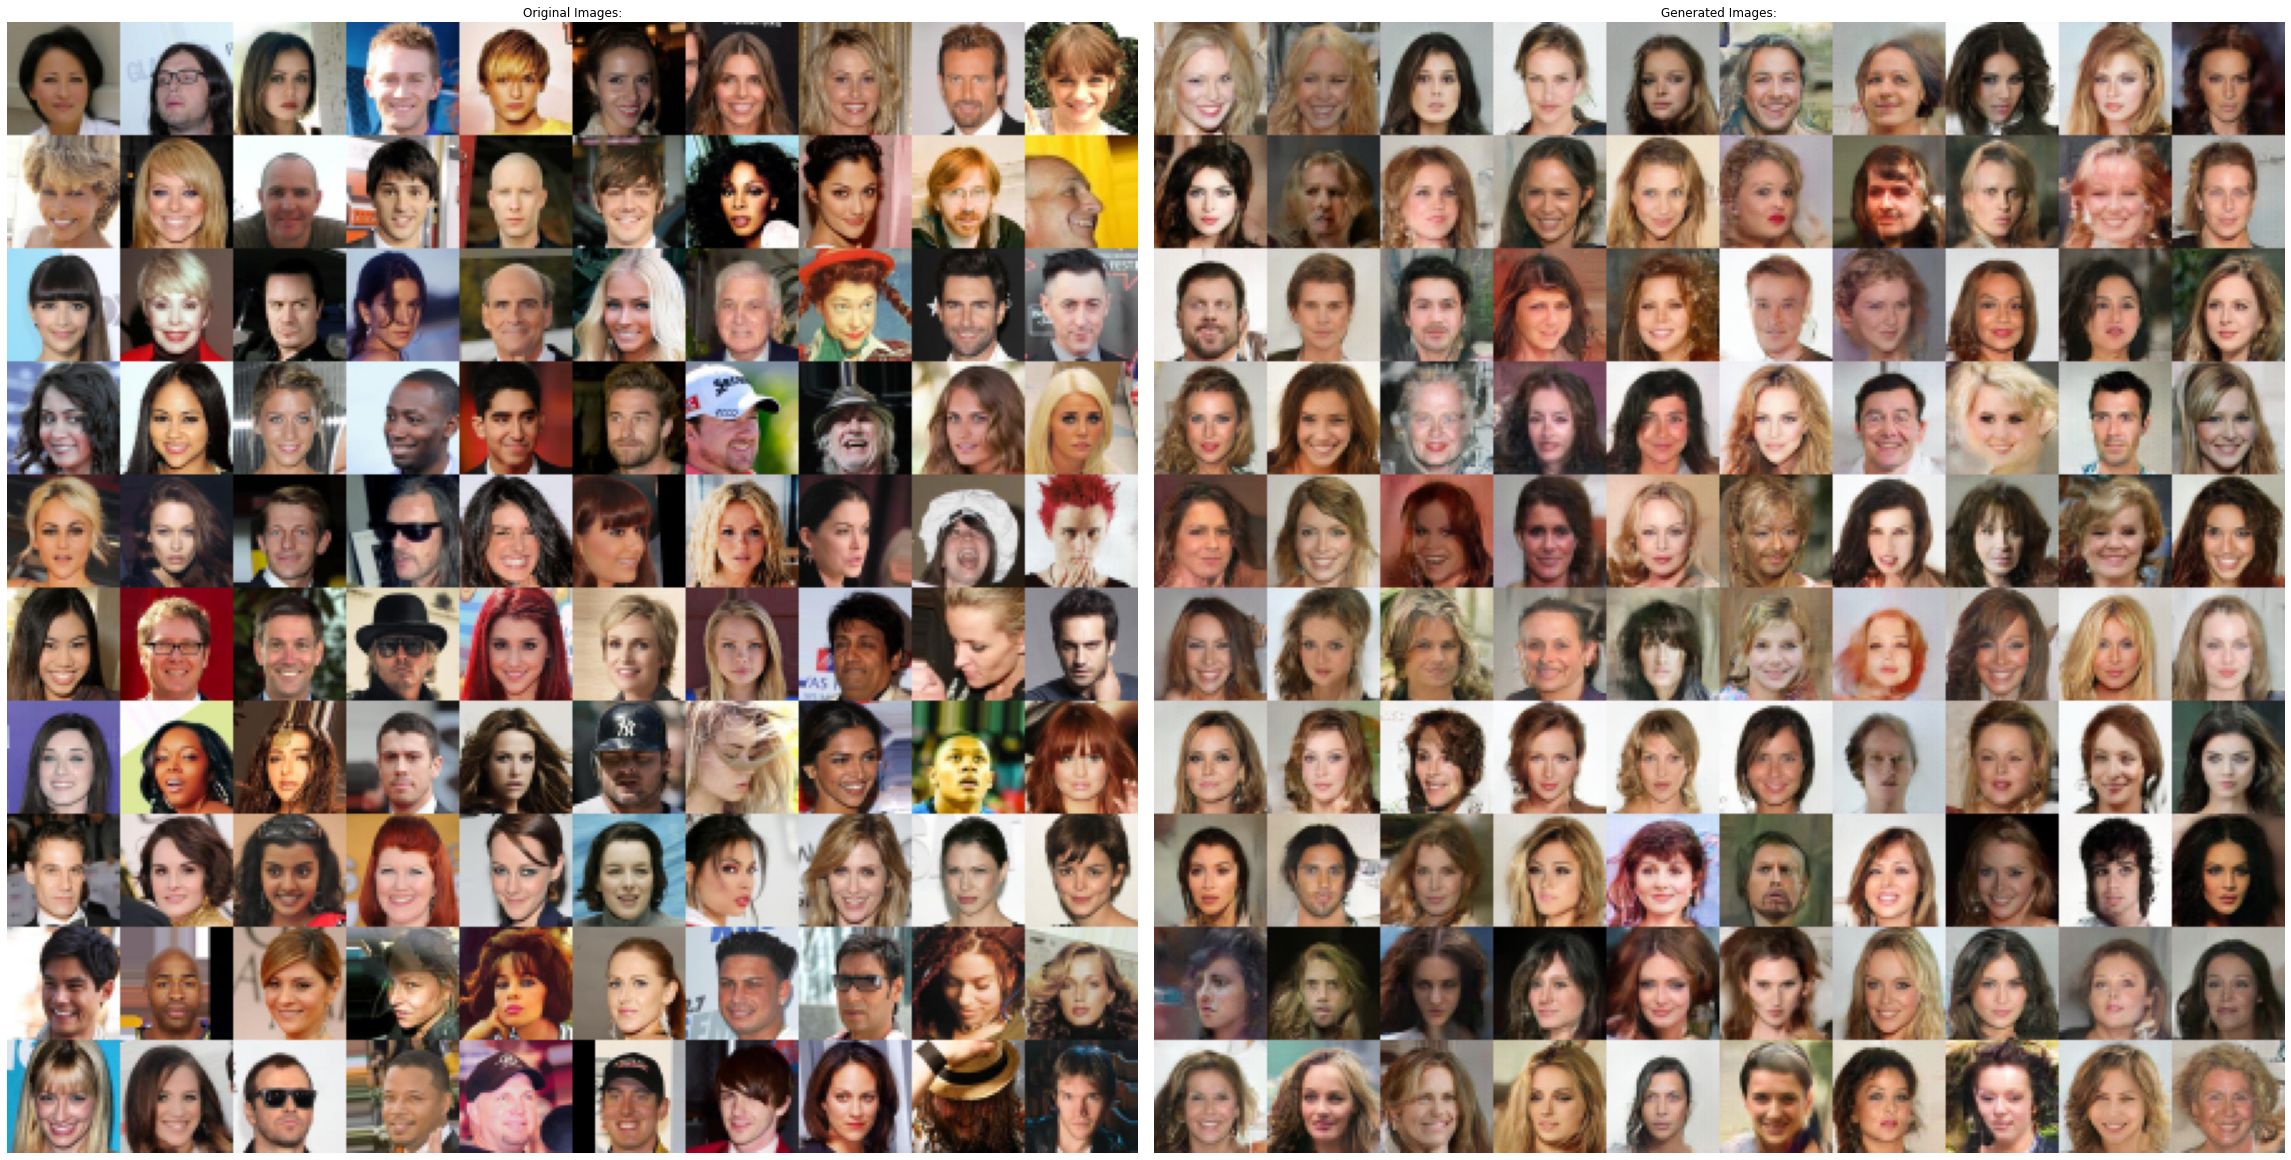

In [12]:
import numpy as np

plt.figure(figsize=[32,16])
plt.subplot(1,2,1)
original = X_train[100:200]
plt.imshow(original.reshape(10,10,45,45,3).transpose(0,2,1,3,4).reshape(450,450,3))
plt.axis('off')
plt.title('Original Images:')

plt.subplot(1,2,2)
temperature = 0.85
noise = np.random.randn(100,latent_dim) * temperature
generated = generator_model.predict(noise)
plt.imshow(generated.reshape(10,10,45,45,3).transpose(0,2,1,3,4).reshape(450,450,3))
plt.axis('off')
plt.title('Generated Images:')
plt.tight_layout()
plt.show()

We see that we are getting sharp images albeit with less variety, and occasional distortion.

### Random walk in the image manifold
We can take a random walk in the latent space see how one face gradually evolves into another.

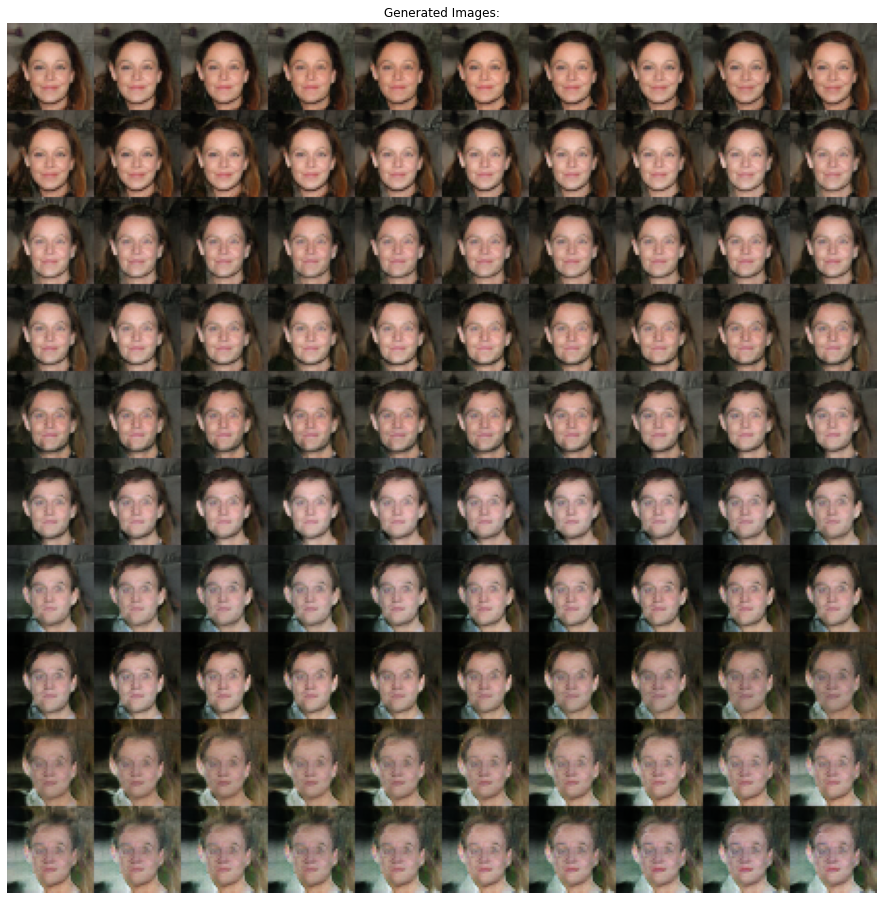

In [21]:
noise_init = np.random.randn(latent_dim)*0.85 
displacements = np.random.randn(100,latent_dim)
displacements = displacements*3/np.linalg.norm(displacements,axis=-1,keepdims=True)
cumulative_displacements = np.cumsum(displacements,axis=0)
noise = noise_init + cumulative_displacements


generated = generator_model.predict(noise)
plt.figure(figsize=[16,16])
plt.imshow(generated.reshape(10,10,45,45,3).transpose(0,2,1,3,4).reshape(450,450,3))
plt.axis('off')
plt.title('Generated Images:')
plt.show()

View the images from left to right and top to bottom.